<a href="https://colab.research.google.com/github/Ahar532/761_Final_Report/blob/main/tiles_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot tiles

This code was used to make a map with the tiles. Its quite long because there are a few different versions.

ChatGPT assisted in writing and debugging this code.

In [ ]:
# --- Colab: setup Google Earth Engine + geemap ---
!pip -q install earthengine-api geemap

import math
import ee, geemap
ee.Authenticate()     # Follow the link shown in the cell output
ee.Initialize(project='geog761-466823') #<- Remember to change this to your own project's name!

In [ ]:
# --- Helper functions: coordinates, sizes, colours ---

# Convert DMS to decimal degrees (lon, lat)
def dms_to_decimal(lon_d, lon_m, lon_s, lon_dir, lat_d, lat_m, lat_s, lat_dir):
    lon = lon_d + lon_m/60 + lon_s/3600
    lat = lat_d + lat_m/60 + lat_s/3600
    if lon_dir.upper() == "W": lon = -lon
    if lat_dir.upper() == "S": lat = -lat
    return lon, lat

# Rectangle size: 4800x7200 px @ 0.1 m/px = 480 m × 720 m
WIDTH_M  = 480.0
HEIGHT_M = 720.0

def meters_to_deg(lat_deg, dx_m, dy_m):
    """Approx local meters->degrees conversion at latitude."""
    m_per_deg_lat = 111_320.0
    m_per_deg_lon = 111_320.0 * math.cos(math.radians(lat_deg))
    dlat = dy_m / m_per_deg_lat
    dlon = dx_m / m_per_deg_lon
    return dlon, dlat

# Legend colours (approx sampled from your swatch)
COLOR_LOW    = '#2CBCC2'   # teal
COLOR_MEDIUM = '#F29A38'   # orange
COLOR_HIGH   = '#C35234'   # brick


In [ ]:
# --- Tile centers (lon, lat) and categories ---

lon1, lat1 = dms_to_decimal(172,43,16,"E", 43,31,3,"S")  # "172°43'16\"E 43°31'3\"S"

tiles = [
    # (risk, id, lon, lat, note)
    ("High",   "BX241229", lon1,                lat1,                 "Suburban/wetland with river"),
    ("High",   "BX241125", 172.6981010,        -43.51146219,         "Wainoni Park"),
    ("High",   "BX241722", 172.6808280,        -43.54901668,         "River/industrial"),
    ("High",   "BX241714", 172.6336605,        -43.54742813,         "Highway/industrial"),
    ("Medium", "BX241420", 172.6683228,        -43.53128358,         "Suburban/main road"),
    ("Medium", "BX241520", 172.6710959,        -43.53552336,         "Park + suburb"),
    ("Medium", "BX241809", 172.6050770,        -43.55770704,         "Suburban + river"),
    ("Medium", "BX241812", 172.6200621,        -43.55659898,         "Industrial"),
    ("Low",    "BX240720", 172.6702853,        -43.48648883,         "Rural/industrial by road"),
    ("Low",    "BX231644", 172.5153499,        -43.54064490,         "Rail + suburban roads"),
    ("Low",    "BX231544", 172.5129460,        -43.53309273,         "Field + suburban edge"),
    ("Low",    "BX231250", 172.5532335,        -43.51814653,         "Suburban + stream"),
]

risk_color = {"Low": COLOR_LOW, "Medium": COLOR_MEDIUM, "High": COLOR_HIGH}


In [ ]:
# --- Build the 2011-02 imagery (Landsat 5 TM true-colour) ---

# Christchurch focus box for filtering (rough bounds)
chch_box = ee.Geometry.Rectangle([172.45, -43.62, 172.78, -43.44])

# Landsat 5 TM, 2011-02-15 to 2011-02-28 (bracketing Feb 22 quake)
col = (ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
       .filterBounds(chch_box)
       .filterDate('2011-02-15', '2011-02-28')
       .filter(ee.Filter.lt('CLOUD_COVER', 40)))

def to_toa_rgb(img):
    # Scale L2 surface reflectance (SR_B* bands) to [0,1] and build true-colour
    sr = img.multiply(0.0000275).add(-0.2)
    rgb = sr.select(['SR_B3','SR_B2','SR_B1'])   # R,G,B
    return rgb.copyProperties(img, img.propertyNames())

rgb2011 = col.map(to_toa_rgb).median().clip(chch_box)

vis_rgb = {'min': 0.03, 'max': 0.3, 'gamma': 1.1, 'bands': ['SR_B3','SR_B2','SR_B1']}


In [ ]:
# --- Build the interactive map, add imagery + tiles, and display ---
import ipywidgets as widgets
from ipyleaflet import Marker, Popup

m = geemap.Map(center=[-43.53, 172.65], zoom=12)

# 2011-02 imagery layer (defined earlier as rgb2011/vis_rgb)
m.addLayer(rgb2011, vis_rgb, 'Aerial (Landsat 5) ~22 Feb 2011')

# Add rectangles (style via FeatureCollection) + center markers with widget popups
for risk, tid, lon, lat, note in tiles:
    # half-size in degrees at this latitude
    dlon, dlat = meters_to_deg(lat, WIDTH_M/2, HEIGHT_M/2)

    # rectangle geometry (lon_min, lat_min, lon_max, lat_max)
    rect_geom = ee.Geometry.Rectangle([lon - dlon, lat - dlat, lon + dlon, lat + dlat])

    # wrap in a 1-feature collection so we can style it
    rect_fc = ee.FeatureCollection([ee.Feature(rect_geom, {"id": tid, "risk": risk})])

    # style polygon (FeatureCollection.style doesn't support fillOpacity; set layer opacity in addLayer)
    styled_rect = rect_fc.style(
        color=risk_color[risk],     # outline color
        fillColor=risk_color[risk], # fill color
        width=2
    )
    m.addLayer(styled_rect, {}, f'{tid} ({risk})', True, 0.25)

    # center marker
    marker = Marker(location=(lat, lon))
    m.add_layer(marker)

    # popup (widget required)
    popup_html = widgets.HTML(
        value=f"<b>{tid}</b> — <i>{risk}</i><br/>{note}"
    )
    popup = Popup(
        location=(lat, lon),
        child=popup_html,
        close_button=True,
        auto_close=False,
        close_on_escape_key=True
    )
    m.add_layer(popup)

# Legend matching your swatch colours
m.add_legend(
    title='Liquefaction Vulnerability',
    legend_dict={'Low': risk_color['Low'], 'Medium': risk_color['Medium'], 'High': risk_color['High']}
)

# Optional: save an interactive HTML
m.save('christchurch_liquefaction_tiles_2011_02.html')

# Display the map
m


Map(center=[-43.53, 172.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 53.8 MB/s eta 0:00:00
Saved: christchurch_tiles_satellite_labeled_v2.png


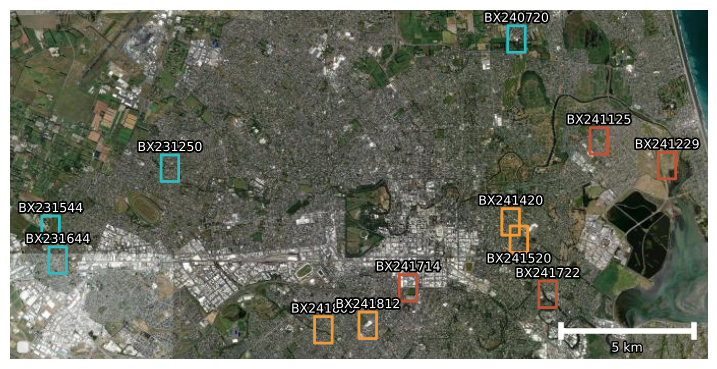

In [ ]:
# Static satellite map with border-only rectangles, labels (above; BX241520 below),
# and a white |---| scale bar moved up/right.

!pip -q install geopandas shapely pyproj contextily

import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patheffects as pe

# --- 1) Data ---------------------------------------------------------------

def dms_to_decimal(lon_d, lon_m, lon_s, lon_dir, lat_d, lat_m, lat_s, lat_dir):
    lon = lon_d + lon_m/60 + lon_s/3600
    lat = lat_d + lat_m/60 + lat_s/3600
    if lon_dir.upper() == 'W': lon = -lon
    if lat_dir.upper() == 'S': lat = -lat
    return lon, lat

lon1, lat1 = dms_to_decimal(172,43,16,"E", 43,31,3,"S")  # ≈ (172.721111, -43.5175)

tiles = [
    ("High",   "BX241229", lon1,                lat1,                 ""),
    ("High",   "BX241125", 172.6981010,        -43.51146219,         ""),
    ("High",   "BX241722", 172.6808280,        -43.54901668,         ""),
    ("High",   "BX241714", 172.6336605,        -43.54742813,         ""),
    ("Medium", "BX241420", 172.6683228,        -43.53128358,         ""),
    ("Medium", "BX241520", 172.6710959,        -43.53552336,         ""),  # special: label below
    ("Medium", "BX241809", 172.6050770,        -43.55770704,         ""),
    ("Medium", "BX241812", 172.6200621,        -43.55659898,         ""),
    ("Low",    "BX240720", 172.6702853,        -43.48648883,         ""),
    ("Low",    "BX231644", 172.5153499,        -43.54064490,         ""),
    ("Low",    "BX231544", 172.5129460,        -43.53309273,         ""),
    ("Low",    "BX231250", 172.5532335,        -43.51814653,         ""),
]

# Rectangle size from 4800x7200 px at 0.1 m/px -> 480 m (W-E) x 720 m (S-N)
HALF_W_M = 240.0
HALF_H_M = 360.0

# --- 2) Build rectangles in NZTM2000 (meters), then project to Web Mercator ----

wgs84_to_nztm = Transformer.from_crs("EPSG:4326", "EPSG:2193", always_xy=True)
records = []
for risk, tid, lon, lat, _ in tiles:
    x_c, y_c = wgs84_to_nztm.transform(lon, lat)
    x_min, x_max = x_c - HALF_W_M, x_c + HALF_W_M
    y_min, y_max = y_c - HALF_H_M, y_c + HALF_H_M
    poly_nztm = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])
    records.append({"risk": risk, "tile_id": tid, "geometry": poly_nztm})

gdf_nztm = gpd.GeoDataFrame(records, crs="EPSG:2193")
gdf_webm = gdf_nztm.to_crs("EPSG:3857")  # for basemap plotting

# --- 3) Plot: basemap + border rectangles + labels -----------------------------

risk_colors = {"Low": "#2CBCC2", "Medium": "#F29A38", "High": "#C35234"}

fig, ax = plt.subplots(figsize=(9, 9))

# Rectangles: border only
for risk in ["High", "Medium", "Low"]:
    subset = gdf_webm[gdf_webm["risk"] == risk]
    if not subset.empty:
        subset.plot(ax=ax, facecolor="none", edgecolor=risk_colors[risk], linewidth=2, label=risk)

# Basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, attribution=False)

# Labels: shift above a bit more; BX241520 below a bit more
offset_up_m = 280   # increased upward offset (was 60)
offset_down_m = 250 # increased downward offset for BX241520

for _, row in gdf_webm.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    cx_center = 0.5 * (minx + maxx)
    if row["tile_id"] == "BX241520":
        y_label = miny - offset_down_m
    else:
        y_label = maxy + offset_up_m

    ax.text(
        cx_center, y_label, row["tile_id"],
        ha="center", va="center", fontsize=9, color="white",
        path_effects=[pe.withStroke(linewidth=2.5, foreground="black")]
    )

ax.set_aspect("equal", adjustable="box")
ax.set_axis_off()
ax.legend(loc="lower left", frameon=True)

# --- 4) White |---| scale bar, moved up and right --------------------------------
def add_scalebar(ax, fraction=0.2):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    width = x1 - x0
    height = y1 - y0

    # choose bar length close to target width
    candidates = [200, 500, 1000, 2000, 5000]
    target = width * fraction
    bar_len = max([c for c in candidates if c <= target] or [candidates[0]])

    # move up a bit and right a bit (closer to edge, higher from bottom)
    pad_x = 0.02 * width   # smaller pad -> further right
    pad_y = 0.08 * height  # larger pad -> higher up
    x_start = x1 - pad_x - bar_len
    x_end   = x1 - pad_x
    y_bar   = y0 + pad_y

    # tick height
    tick_h = 0.018 * height

    # draw |---| in white
    ax.plot([x_start, x_end], [y_bar, y_bar], color="white", linewidth=4, solid_capstyle="butt")
    ax.plot([x_start, x_start], [y_bar - tick_h, y_bar + tick_h], color="white", linewidth=4)
    ax.plot([x_end,   x_end],   [y_bar - tick_h, y_bar + tick_h], color="white", linewidth=4)

    # label (white with black halo) just below the bar
    label = f"{int(bar_len/1000)} km" if bar_len >= 1000 else f"{bar_len} m"
    ax.text(
        (x_start + x_end)/2, y_bar - 0.03*height, label,
        ha="center", va="top", fontsize=9, color="white",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

add_scalebar(ax, fraction=0.2)

# Save
out_png = "christchurch_tiles_satellite_labeled_v2.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
print("Saved:", out_png)


Saved: christchurch_tiles_satellite_zoomed_out.png


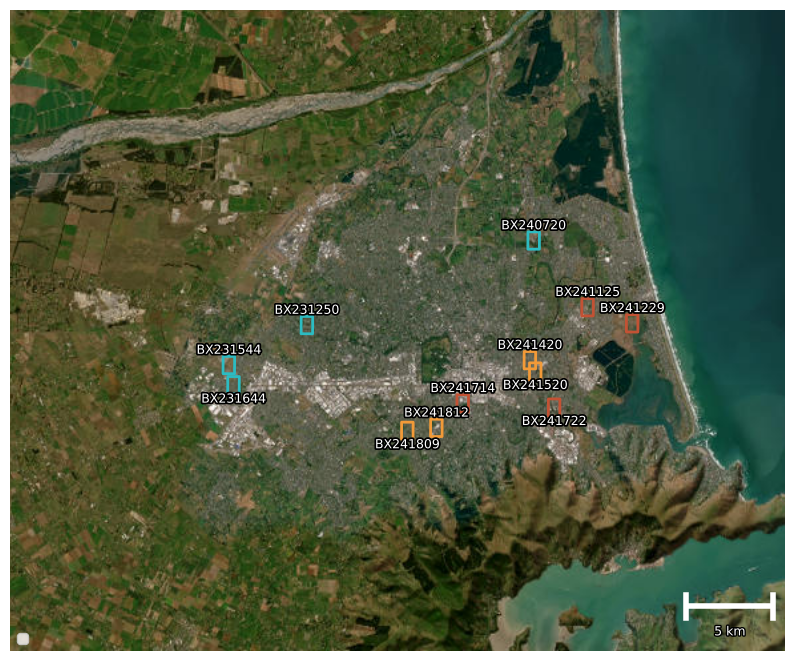

In [ ]:
# --- Plot: zoomed-out Greater Christchurch extent ------------------------------
import matplotlib.pyplot as plt
import contextily as cx
from pyproj import Transformer
import matplotlib.patheffects as pe
import ipywidgets as widgets
from ipyleaflet import Marker, Popup

risk_colors = {"Low": "#2CBCC2", "Medium": "#F29A38", "High": "#C35234"}

fig, ax = plt.subplots(figsize=(10, 10))

# 1) Set a WGS84 bbox that matches your reference map (tweak if needed)
#    [min_lon, min_lat, max_lon, max_lat]
CHCH_BBOX_WGS84 = [172.40, -43.64, 172.80, -43.40]  # west..east, south..north

# Convert bbox to Web Mercator and apply as axes limits BEFORE adding basemap
wgs84_to_webm = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x0, y0 = wgs84_to_webm.transform(CHCH_BBOX_WGS84[0], CHCH_BBOX_WGS84[1])
x1, y1 = wgs84_to_webm.transform(CHCH_BBOX_WGS84[2], CHCH_BBOX_WGS84[3])
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)

# 2) Basemap (Esri World Imagery) for the larger extent
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, attribution=False)

# 3) Draw rectangles (border-only)
for risk in ["High", "Medium", "Low"]:
    subset = gdf_webm[gdf_webm["risk"] == risk]
    if not subset.empty:
        subset.plot(ax=ax, facecolor="none", edgecolor=risk_colors[risk], linewidth=2, label=risk)

# 4) Labels (adjust offsets as you like to avoid overlap)
# --- Labels: above by default; specific tiles below ---
offset_up_m   = 350    # move labels above rectangles by this many meters
offset_down_m = 300    # move selected labels below rectangles by this many meters

labels_below = {"BX241520", "BX241809", "BX231644", "BX241722"}

for _, row in gdf_webm.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    x_center = 0.5 * (minx + maxx)
    place_below = row["tile_id"] in labels_below
    y_label = (miny - offset_down_m) if place_below else (maxy + offset_up_m)

    ax.text(
        x_center, y_label, row["tile_id"],
        ha="center", va="center", fontsize=9, color="white",
        path_effects=[pe.withStroke(linewidth=2.5, foreground="black")]
    )


# 5) White |---| scale bar (position uses fraction of current extent)
def add_scalebar(ax, fraction=0.2, pad_x_frac=0.015, pad_y_frac=0.07):
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    width  = x1 - x0;       height = y1 - y0
    # choose a bar length near target width
    candidates = [200, 500, 1000, 2000, 5000, 10000]
    target = width * fraction
    bar_len = max([c for c in candidates if c <= target] or [candidates[0]])
    # position (adjust pad_x_frac/pad_y_frac to move right/left or up/down)
    x_end   = x1 - pad_x_frac * width
    x_start = x_end - bar_len
    y_bar   = y0 + pad_y_frac * height
    tick_h  = 0.018 * height
    # draw |---|
    ax.plot([x_start, x_end], [y_bar, y_bar], color="white", linewidth=4, solid_capstyle="butt")
    ax.plot([x_start, x_start], [y_bar - tick_h, y_bar + tick_h], color="white", linewidth=4)
    ax.plot([x_end,   x_end],   [y_bar - tick_h, y_bar + tick_h], color="white", linewidth=4)
    # label
    label = f"{int(bar_len/1000)} km" if bar_len >= 1000 else f"{bar_len} m"
    ax.text((x_start + x_end)/2, y_bar - 0.03*height, label,
            ha="center", va="top", fontsize=9, color="white",
            path_effects=[pe.withStroke(linewidth=2, foreground="black")])

add_scalebar(ax, fraction=0.18, pad_x_frac=0.015, pad_y_frac=0.07)

# 6) Finish
ax.set_aspect("equal", adjustable="box")
ax.set_axis_off()
ax.legend(loc="lower left", frameon=True)

out_png = "christchurch_tiles_satellite_zoomed_out.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
print("Saved:", out_png)
